1. 데이터 불러오기/변환
2. Overview
  + [ ] 수집 체널 List
3. 당월자료 Summary : Graph
  + [ ] 유형별 수집자료 : 수치, 비율, 전월대비 증/감율
  + [x] Trend
  + [x] 비율
  + [ ] Wordcloud(A/B/C) : color 설정
  + [ ] 연관단어(keyword 기준)
3. 이메일 양식 작성

In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# from konlpy.tag import Okt
# okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)
from matplotlib.font_manager import FontProperties

prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
plt.rcParams['font.family'] = prop.get_family()


# 분석1 : Trend 탐식 시, 이상치 확인
from sklearn.neighbors import LocalOutlierFactor

# 분석2 : wordcloud 준비
from wordcloud import WordCloud

# 분석3 : text rank 도출
import itertools
import nltk

# 시간기록
from datetime import datetime, timedelta
import time 

# 내용공유(e-mail, 회사) 
# import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [2]:
# 제품군 정보
category_group = '셀렉스'
category_en = 'selex'
category = [['코어프로틴분말', '비리다'],
            ['코어프로틴분말', '냄새'],
            ['코어프로틴분말', '맛없다'],
            ['코어프로틴분말', '녹다'],
            ['밀크세라마이드', '달다'],
            ['밀크세라마이드', '비싸다'],
            ['밀크세라마이드', '비리다'],
            ['밀크세라마이드', '효과'],
            ['밀크세라마이드', '맛없다'],
            ['밀크세라마이드', '뭉치다'],
            ['슬림25', '녹다'],
            ['슬림25', '안 녹다'],
            ['코어프로틴바', '식감'],
            ['코어프로틴바', '딱딱'],
            ['스포츠RTD', '냄새'],
            ['스포츠RTD', '향']]


In [2]:
category_group = '상하목장'
category_en = 'sangha'
category = [['상하 우유',  '비리다'],
            ['상하 우유',  '냄새'  ],
            ['상하 우유',  '맛없다'],
            ['상하 우유',  '녹다'  ],
            ['아이스크림', '녹다'  ],
            ['아이스크림', '달다'  ],
            ['아이스크림', '파손'  ] ]

In [2]:
category_group = '아몬드브리즈'
category_en = 'almond'
category = [['아몬드브리즈', '비리다'],
            ['아몬드브리즈', '냄새'  ],
            ['아몬드브리즈', '맛없다'],
            ['아몬드브리즈', '밍밍']
           ]


In [44]:
category_group = '두유'
category_en = 'soymilk'
category = [['두유', '비리다'],
            ['두유', '냄새'  ], 
            ['두유', '맛없다'],
            ['두유', '밍밍'  ],
            ['두유', '달다'  ]
           ]


In [126]:
category_group

'상하목장'

### I.데이터 불러오기

In [52]:
# 제품군 정보
df_product = pd.read_excel('./PRODUCT.xlsx','Sheet1')
df_product['PRODUCT_CODE'] = df_product['PRODUCT_CODE'].astype(object)
df_product = df_product[df_product['category1'] == category_group ]

In [53]:
query_values = tuple(df_product.PRODUCT_CODE.to_list())
query_values = str(query_values)

In [54]:
# query_values

In [55]:
#########
# rawdata 불러오기
###

# DB연결
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)


In [56]:
# 쿼리실행: 전체리뷰
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , trim(A.CONTENTS) as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집채널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in ''' + query_values + '''and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between LAST_DAY(NOW() - interval 1 month) + interval 1 DAY and DATE_ADD(curdate(),INTERVAL -1 day)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT desc
        '''
cursor.execute(sql)
df_review_all = cursor.fetchall()
df_review_all = pd.DataFrame(df_review_all)
df_review_all['리뷰등록일'] = pd.to_datetime(df_review_all['리뷰등록일'])
df_review_all = df_review_all.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')

df_review_all = df_review_all.join(df_product.set_index('상품명')['category2'], on='상품명')
df_review_all = df_review_all[df_review_all.columns[2:]].drop_duplicates().reset_index(drop=True)

df_review_all['리뷰등록일'] = df_review_all['리뷰등록일'].dt.strftime('%m/%d')

In [57]:
df_review_all['리뷰상세내용'] = df_review_all['리뷰상세내용'].dropna()

In [59]:
# # Excel 자료 저장 v2
# now = datetime.today()    # 현재
# date = now.strftime('%Y%m%d')

# writer = pd.ExcelWriter('./'+ date+ '_review_all.xlsx')
# df_review_all.to_excel(writer, 'Sheet1')
# writer.save()

In [60]:
if category_group == '상하목장':
    df_review_2 = pd.read_excel('./kurly_review.xlsx','Sheet1')
    df_review_2 = df_review_2[['구매자평점', '리뷰상세내용', '리뷰등록일', '수집채널', 'category2']]
    df_review_2['리뷰등록일'] = pd.to_datetime(df_review_2['리뷰등록일'])
    df_review_2['리뷰등록일'] = df_review_2['리뷰등록일'].dt.strftime('%m/%d')
    df_review_2['구매자평점'] = df_review_2['구매자평점'].astype('int')

    df_review_all= pd.concat([df_review_all,df_review_2],axis=0, ignore_index=True)
    df_review_all['구매자평점'] = df_review_all['구매자평점'].apply(str)
else:
    pass

In [61]:
# df_review_all.groupby('수집채널').count()

In [65]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('언스위트', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')

def tokenize(doc):
    try:
        result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    except:
        result = ''
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [66]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all['token'] = df_temp1
df_review_all['token_attribution'] = token_all

In [63]:
# writer = pd.ExcelWriter('./_review_temp.xlsx')
# df_temp1.to_excel(writer, 'Sheet1')
# writer.save()

In [30]:
df_review_all.tail()

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token
13672,5,\n깔끔한 맛? 좋아요. 상하버터~,09/08,마켓컬리,버터,NaN
13673,5,\n버터를 적게 사용하는 사람에게는 소량씩 살 수 있어서 좋네요.,09/08,마켓컬리,버터,NaN
13674,5,\n좋은제품 감사합니다~!!5656,09/08,마켓컬리,버터,NaN
13675,4,\n생각보다 작은데 애기 먹이려고 산거라 괜찮네요 맛있어요,09/08,마켓컬리,버터,NaN
13676,5,\n재구매에요 과하게 느끼하지 않고 깔끔한 느낌이라 제 입맛에는 괜찮았구요 제가 우...,09/08,마켓컬리,버터,NaN


In [131]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all_before['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all_before['token'] = df_temp1
df_review_all_before['token_attribution'] = token_all

In [8]:
##########
#데이터 불리하기
###

# 당월 부정/긍정/중립 리뷰
df_review_neg= df_review_all[(df_review_all['구매자평점']=='1')|(df_review_all['구매자평점']=='2')]
df_review_pos= df_review_all[(df_review_all['구매자평점']=='4')|(df_review_all['구매자평점']=='5')]
df_review_nue= df_review_all[(df_review_all['구매자평점']=='3')]

# 전월 부정/긍정/중립 리뷰
df_review_neg_before= df_review_all_before[(df_review_all_before['구매자평점']=='1')|(df_review_all_before['구매자평점']=='2')]
df_review_pos_before= df_review_all_before[(df_review_all_before['구매자평점']=='4')|(df_review_all_before['구매자평점']=='5')]
df_review_nue_before= df_review_all_before[(df_review_all_before['구매자평점']=='3')]


NameError: name 'df_review_all_before' is not defined

In [68]:
# print('<<기간 내 리뷰수>>' )
# print(' - 긍정(54   ) : {:,.0f}'.format(len(df_review_pos)) )
# print(' - 중립(  3  ) : {:,.0f}'.format(len(df_review_nue)) )
# print(' - 부정(   21) : {:,.0f}'.format(len(df_review_neg)) )

In [69]:
# print('<<기간 내 리뷰수 비중>>' )
# print(' - 긍정(54   ) : {:,.1f}%'.format(len(df_review_pos)/len(df_review_all)*100 ) )
# print(' - 중립(  3  ) : {:,.1f}%'.format(len(df_review_nue)/len(df_review_all)*100 ) )
# print(' - 부정(   21) : {:,.1f}%'.format(len(df_review_neg)/len(df_review_all)*100 ) )

In [133]:
print('<<기간 내 리뷰 증감률>>' )
print(' - 전체(54321) : {:,.1f}%'.format( (len(df_review_all)-len(df_review_all_before))/len(df_review_all_before)*100 ) )
print(' - 긍정(54   ) : {:,.1f}%'.format( (len(df_review_pos)-len(df_review_pos_before))/len(df_review_pos_before)*100 ) )
print(' - 중립(  3  ) : {:,.1f}%'.format( (len(df_review_nue)-len(df_review_nue_before))/len(df_review_nue_before)*100 ) )
print(' - 부정(   21) : {:,.1f}%'.format( (len(df_review_neg)-len(df_review_neg_before))/len(df_review_neg_before)*100 ) )

<<기간 내 리뷰 증감률>>
 - 전체(54321) : 86.0%
 - 긍정(54   ) : 84.3%
 - 중립(  3  ) : 136.0%
 - 부정(   21) : 488.9%


In [134]:
df_review_neg.head(2)

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
272,1,맛도 별로도 오리지널만 있는줄 알았는데 바나나 맛잇네요ㅠ. 바나나 한박스 다 버렸어...,08/15,3 네이버,아몬드브리즈,맛 도 별로 도 오리 지 널 만 있다 알다 바나나 맛 잇다 ㅠ 바나나 하다 박스 ...,"[맛/Noun, 도/Josa, 별로/Noun, 도/Josa, 오리/Noun, 지/J..."
353,2,스쿼트밴드 이미지 있을 때 구입했는데 밴드가 안왔어요..,08/15,3 네이버,아몬드브리즈,스쿼트 밴드 이미지 있다 때 구입 하다 밴드 가 안 오다 어요,"[스쿼트/Noun, 밴드/Noun, 이미지/Noun, 있다/Adjective, 때/..."


### III.데이터 리포팅

In [9]:
from dateutil.relativedelta import relativedelta


#당월 날짜 생성
start = (datetime.today().replace(day=1)).strftime('%Y-%m-%d')
end = ((datetime.today()+relativedelta(months=1)).replace(day=1)-timedelta(days=1)).strftime('%Y-%m-%d')

monthly_date = [d.strftime('%Y-%m-%d') for d in pd.date_range(start, end, freq='D')]

REPORT = pd.DataFrame()
REPORT['리뷰등록일'] = monthly_date

In [10]:
REPORT.head()

,리뷰등록일
0,2021-09-01
1,2021-09-02
2,2021-09-03
3,2021-09-04
4,2021-09-05


In [11]:
trend_review_all = pd.pivot_table(df_review_all, index = '리뷰등록일', values = '리뷰상세내용', columns = '구매자평점', aggfunc = 'count').fillna(0)

trend_review_pos = pd.pivot_table(df_review_pos, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_nue = pd.pivot_table(df_review_nue, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_neg = pd.pivot_table(df_review_neg, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)


In [12]:
trend_review_pos.index = trend_review_pos.index.map(str)

In [13]:
trend_review_pos.index

Index(['09/01'], dtype='object', name='리뷰등록일')

In [14]:
trend_review_pos.index.astype(str, copy = False)

Index(['09/01'], dtype='object', name='리뷰등록일')

In [15]:

REPORT_01 = pd.merge(REPORT, trend_review_pos, left_on=['리뷰등록일'], right_on=trend_review_pos.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '긍정리뷰' }, inplace = True)

REPORT_01 = pd.merge(REPORT_01, trend_review_nue, left_on=['리뷰등록일'], right_on=trend_review_nue.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '중립리뷰' }, inplace = True)

REPORT_01 = pd.merge(REPORT_01, trend_review_neg, left_on=['리뷰등록일'], right_on=trend_review_neg.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '부정리뷰' }, inplace = True)
# REPORT_01 = REPORT_01.fillna('')

# REPORT_01['리뷰등록일'] = REPORT_01['리뷰등록일'].str.slice(start=-5)
# REPORT_01['리뷰등록일'] = REPORT_01['리뷰등록일'].str.replace('-', '/')

In [142]:
###############
# 리포트용 자료 만들기 : 2.Trend &  Wordcloud
#####

# word cloud 생성 모듈
def wordcloud_gen(dataset, color):
    text = dataset.to_list()
    text_all = listToString(text)
    wc1 = WordCloud(font_path= path, stopwords = stopword, width = 600, height = 600, background_color="white", repeat=True, colormap = color)
    return wc1.generate(text_all)

In [151]:
stopword = ['먹다', '하다', '좋다'  , '예요', '이에요', '있다', '맛있다', '같다', '없다', '보통', '최고', '주문', '보다', '매일',
         '구매', '에서', '먹이다', '않다', '자다'  , '들다', '사다'  , '되다', '으로', 'ㅠㅠ', 'ㅜㅜ', '말다', '이다', '받다',
         '아직', '이다', '보이다', '이나', '오다'  , '이라', '우유'  , '배달', '배송', '가정', '제품', '신청', '문의', '되어다',
         '넘다', 'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', '진짜'  , '너무', '이', '는', '요', '은', '에', '기', '다', '도', '원', '구', '개', '랑','가',
         '도', '임시', '이미지', '확인', '후', '을', '안' ,'되다', '하', '심', '고객', '님', '어요', '좀', '것', '니', '어보', '타',
         '생각', '지만', '잘', '제', '니다', '네', '해', '그래도', '엄청', '하고', '번', '그', '나다', '시', '다가', '한', '해서', '로',
         '더', '못', '에는', '던데', '일단', '나요', '아하', '이적','이고', '려고', '이라고', '고', '어서','를', '그냥', '만', '짧다',
         '유통기한', '인데', '박스', '까지', '일', '월', '두', '팩','어요', '요','다', '한', '있다', '라', '나', '게', '거', '데',
         '더니','달', '보', '이번', '이네', '내주', '하나', '수', '저', '이렇다', '이렇게', 'ㅠ', '때', '늘', '또', '편', '늘','감사',
         '항상', '여', '아해', '들', '중', '열', '영', '분', '세', '뭐', '루', '알', '용', '통', '함', '무', '생', '물', '리', '새',
         '적', 'hellip', '빠르다', '도착', '배송', '택배', '두유', '아주', '지', '아몬드브리즈', '아몬드 브리즈', '브리', '즈', '아주',
         '씩', '오리', '널', '에요', '에도', '네요','잇다', '알다', '포장', '옵션', '상품', '많이', '대하'
         ]

In [18]:
# 전월동기 대비 증감율 자료
review_all_count  = len(df_review_all)
review_all_ratio  = len(df_review_all)/len(df_review_all)*100
review_all_change = (len(df_review_all)-len(df_review_all_before)) /len(df_review_all_before)*100

NameError: name 'df_review_all_before' is not defined

In [19]:
termA_start

'09/01'

In [20]:
###############
# 리포트용 자료 만들기 : 주요단어 Rank
#####

# 날짜 지정
termA_start = (df_review_all.리뷰등록일.min())
termA_end   = (df_review_all.리뷰등록일.max())
termB_start = (df_review_all_before.리뷰등록일.min())
termB_end   = (df_review_all_before.리뷰등록일.max())

# 자료가공
df_review_pos_termA = df_review_pos[df_review_pos.리뷰등록일.between(termA_start, termA_end)]
df_review_pos_termB = df_review_pos_before[df_review_pos_before.리뷰등록일.between(termB_start, termB_end)]

df_review_nue_termA = df_review_nue[df_review_nue.리뷰등록일.between(termA_start, termA_end)]
df_review_nue_termB = df_review_nue_before[df_review_nue_before.리뷰등록일.between(termB_start, termB_end)]

df_review_neg_termA = df_review_neg[df_review_neg.리뷰등록일.between(termA_start, termA_end)]
df_review_neg_termB = df_review_neg_before[df_review_neg_before.리뷰등록일.between(termB_start, termB_end)]


NameError: name 'df_review_all_before' is not defined

In [17]:
df_review_pos_termA

NameError: name 'df_review_pos_termA' is not defined

In [149]:

list_pos_termA = list(itertools.chain(*df_review_pos_termA.token_attribution))
list_pos_termB = list(itertools.chain(*df_review_pos_termB.token_attribution))

list_nue_termA = list(itertools.chain(*df_review_nue_termA.token_attribution))
list_nue_termB = list(itertools.chain(*df_review_nue_termB.token_attribution))

list_neg_termA = list(itertools.chain(*df_review_neg_termA.token_attribution))
list_neg_termB = list(itertools.chain(*df_review_neg_termB.token_attribution))


def wordrank(dataset):
    ko = nltk.Text(dataset)
    
    data = ko.vocab().items()
    reviw_word_all = pd.DataFrame.from_dict(data)
    reviw_word_all.rename(columns = { 1 : 'count' }, inplace = True)
    reviw_word_all = reviw_word_all.sort_values('count', ascending=False)
    reviw_word_all['속성'] =reviw_word_all[0].str.split('/').str[1]
    reviw_word_all['내용'] =reviw_word_all[0].str.split('/').str[0]

    # stopword 내용 삭제
    reviw_word_all = reviw_word_all[~reviw_word_all.내용.isin(stopword)]

    # 일부 속성 삭제
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Punctuation')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Josa')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Foreign')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'KoreanParticle')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Number')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Adverb')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Exclamation')]

    # top15 만 지정
    reviw_word_all = reviw_word_all[['속성', '내용', 'count']]

    return reviw_word_all


AttributeError: 'DataFrame' object has no attribute '부정리뷰'

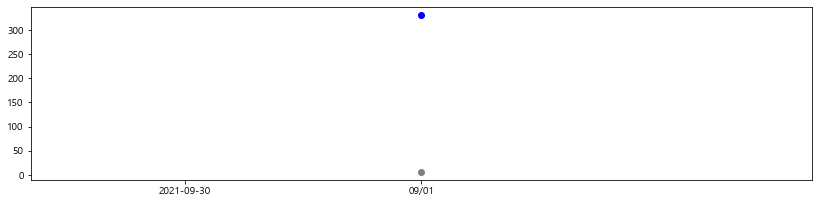

In [21]:
fig = plt.figure(figsize=(14, 30))

###############
# 당월 리뷰내용 요약
#####
# ax1 = plt.subplot2grid((7, 4), (0, 0))
# plt.xticks([]); plt.yticks([]); plt.grid(False)
# plt.axis([0, 2, 0, 2])
# plt.text(1, 1, ha = 'center', va = 'center', fontsize =16, 
#          s='{}월 리뷰누계\n: {:,.0f}개\n(전월동기 : {:,.0f}%)\n\n(비중 : {:,.0f}%)'.format(datetime.now().strftime('%m'), review_all_count, review_all_change, review_all_ratio ) )

# ax2 = plt.subplot2grid((7, 4), (0, 1))
# plt.xticks([]); plt.yticks([]); plt.grid(False)
# plt.axis([0, 2, 0, 2])
# plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'blue', 
#          s='{}월 긍정리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_pos),len(df_review_pos)/len(df_review_all)*100 ) )

# ax3 = plt.subplot2grid((7, 4), (0, 2))
# plt.xticks([]); plt.yticks([]); plt.grid(False)
# plt.axis([0, 2, 0, 2])
# plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'gray',
#          s='{}월 중립리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_nue),len(df_review_nue)/len(df_review_all)*100 ) )

# ax4 = plt.subplot2grid((7, 4), (0, 3))
# plt.xticks([]); plt.yticks([]); plt.grid(False)
# plt.axis([0, 2, 0, 2])
# plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'red',
#          s='{}월 부정리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_neg),len(df_review_neg)/len(df_review_all)*100 ) )


###############
# 일별 리뷰내용 추이
#####
ax5 = plt.subplot2grid((7, 4), (1, 0), colspan=4)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(REPORT_01.리뷰등록일, REPORT_01.긍정리뷰, marker="o", color= 'blue', label='긍정')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.중립리뷰, marker="o", color= 'gray', label='중립')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.부정리뷰, marker="o", color= 'red',  label='부정')
lgd = plt.legend(loc='best',fancybox=True, shadow=True)
plt.title('일별 리뷰건수',fontsize='x-large')
plt.xticks(rotation=45)
plt.xlim(-1,31)


###############
# 일별 리뷰내용 비율
#####
ax6 = plt.subplot2grid((7, 4), (2, 0), colspan=4)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
pd.crosstab(df_review_all.리뷰등록일, df_review_all.구매자평점, normalize='index').plot.bar(stacked=True,  ax = ax6)
lgd = plt.legend(loc='best',fancybox=True, shadow=True)
plt.title('일별 리뷰 비중',fontsize='x-large')
plt.xlim(-1,31)
plt.xticks(rotation=45)

###############
# word cloud
#####

ax7 = plt.subplot2grid((7, 4), (3, 0))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all['token'], None), cmap=plt.cm.binary)
plt.title('전체리뷰',fontsize='large')

ax8 = plt.subplot2grid((7, 4), (3, 1))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_pos['token'], 'Blues_r'), cmap=plt.cm.binary)
plt.title('긍정리뷰',fontsize='large')

ax9 = plt.subplot2grid((7, 4), (3, 2))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_nue['token'], 'gray'), cmap=plt.cm.binary)
plt.title('중립리뷰',fontsize='large')

ax10 = plt.subplot2grid((7, 4), (3, 3))
plt.xticks([]); plt.yticks([]); plt.grid(False)
try:
    plt.imshow(wordcloud_gen(df_review_neg['token'], 'Reds'), cmap=plt.cm.binary)
except:
    pass
plt.title('부정점수',fontsize='large')

plt.savefig('./image.png', bbox_inches='tight', dpi=200)

# ax11 = plt.subplot2grid((7, 4), (4, 0))


plt.show()

In [559]:
###############
# 리포트용 자료 만들기 : 5.키워드별 rawdata
#####

data_by_keyword = pd.DataFrame()

category_count = []
for text1 ,text2 in category :
    df_sort = df_review_all[(df_review_all['token'].str.contains(str(text2)))]
    df_sort = df_sort[(df_sort['category2'].str.contains(str(text1)))][['리뷰등록일','수집채널','리뷰상세내용','구매자평점', 'category2']]
    df_sort = df_sort.drop_duplicates()
    if len(df_sort) > 0:
        df_sort['키워드'] = text2
        category_count.append(len(df_sort))
        data_by_keyword = pd.concat([df_sort, data_by_keyword]) 
    else:
        category_count.append(int(0))
        
report_05 = pd.DataFrame(category)
report_05 = report_05.rename(columns={0: "Category", 1: "키워드"})
report_05['리뷰개수'] = category_count

In [560]:
report_05

,Category,키워드,리뷰개수
0,아몬드브리즈,비리다,3
1,아몬드브리즈,냄새,1
2,아몬드브리즈,맛없다,12
3,아몬드브리즈,밍밍,50
4,두유,비리다,19
5,두유,냄새,2
6,두유,맛없다,13
7,두유,밍밍,37
8,두유,달다,80


In [561]:
data_by_keyword

,리뷰등록일,수집채널,리뷰상세내용,구매자평점,category2,키워드
482,2021-07-22,3 네이버,"자주 먹던건데, 단백질 두유보단 더 달아요",5,두유,달다
485,2021-07-22,3 네이버,다른 제품은 너무 달아서 바꿔봤는데 많이 달지 않고 건강하게 꾸준히 먹을 수 있을 ...,5,두유,달다
512,2021-07-22,3 네이버,맛있어요~ \n완전 달진 않으나 고소한 맛이 👍,5,두유,달다
657,2021-07-22,3 네이버,많이 비리지 않고 적당히 달아서 괜찮았어요!,5,두유,달다
662,2021-07-22,3 네이버,처음먹어보는 고단백 두유인데 생각보다 늦게 하지 않고 적당히 달아요,5,두유,달다
...,...,...,...,...,...,...
7992,2021-08-04,3 네이버,맛있어요 누가맛없다했는데 두유맛임,5,아몬드브리즈,맛없다
1192,2021-07-23,3 네이버,사은품과 같이 배송되었어요\n드라이백만 구입하려해도 몇만원하는데^^\n품질도 좋고 ...,5,아몬드브리즈,냄새
578,2021-07-22,3 네이버,두유에서 비린맛 나서 싫으신분들이면 좋아할꺼같아요 ㅎㅎ 묵직한 느낌은 없고 가벼운느...,5,아몬드브리즈,비리다
5496,2021-07-30,3 네이버,비린내 없고 깔끔한 맛이 너무 좋아요!!,5,아몬드브리즈,비리다


In [56]:
# df_review_neg.head()

In [59]:
remove_word = ['빠르다', '도착', '배송']
pattern = '|'.join(remove_word)
REPORT_02 = df_review_nue.loc[ ~df_review_nue['token'].str.contains(pattern, case=False) ].head(10)


In [60]:
REPORT_02

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
69,3,항상 먹는 두유376시,2021-08-10,3 네이버,두유,항상 먹다 두유 시,"[항상/Noun, 먹다/Verb, 두유/Noun, 376시/Number]"
78,3,입맛에 안맞았어요 ㅠㅠㅠ,2021-08-10,3 네이버,두유,입맛 에 안 맞다 어요 ㅠㅠㅠ,"[입맛/Noun, 에/Josa, 안/VerbPrefix, 맞다/Verb, 어요/No..."
153,3,세번째 구매입니다. 맛있어요,2021-08-10,3 네이버,두유,세번 째다 구 매입 니 다 맛있다 어요,"[세번/Noun, 째다/Verb, 구/Noun, 매입/Noun, 니/Josa, 다/..."
164,3,저렴하게 잘샀어요. 많이 달지 않고 단백하고 고소해요,2021-08-10,3 네이버,두유,저렴 하다 잘 사다 어요 많이 달 지 않다 단백 하고 고소 해 요,"[저렴/Noun, 하다/Verb, 잘/VerbPrefix, 사다/Verb, 어요/N..."
203,3,맛있어요\n게다가 건강한 맛,2021-08-10,3 네이버,두유,맛있다 어요 게다가 건강 한 맛,"[맛있다/Adjective, 어요/Noun, 게다가/Noun, 건강/Noun, 한/..."
234,3,단맛이 생각보다는 적습니다. 단백하고 맛있어요,2021-08-10,3 네이버,두유,단맛 이 생각 보다는 적다 단백 하고 맛있다 어요,"[단맛/Noun, 이/Josa, 생각/Noun, 보다는/Josa, 적다/Verb, ..."
252,3,골고루 먹고 있는데 고단백은 첨인데 아들 운동후 괜찮을것 같네요,2021-08-10,3 네이버,두유,골 고루 먹다 있다 고 단백 은 첨 인데 아들 운동 후 괜찮다 같다,"[골/Noun, 고루/Noun, 먹다/Verb, 있다/Adjective, 고/Nou..."
374,3,가성비 대비 괜찮았고 달지 않네요.,2021-08-09,3 네이버,두유,가성 비 대비 괜찮다 달 지 않다,"[가성/Noun, 비/Noun, 대비/Noun, 괜찮다/Adjective, 달/No..."
375,3,떨어지지 않게 시켜먹습니다,2021-08-09,3 네이버,두유,떨다 지지 않다 시키다 먹다,"[떨다/Verb, 지지/Noun, 않다/Verb, 시키다/Verb, 먹다/Verb]"
457,3,너무 싱거워요 물탄듯한 맛이에요! 아쉽네요!,2021-08-09,3 네이버,두유,너무 싱겁다 물탄 듯 한 맛 이에요 아쉽다,"[너무/Adverb, 싱겁다/Adjective, 물탄/Noun, 듯/Noun, 한/..."


In [562]:
##########
# Excel 파일 생성(using XlsxWriter)
###

date2 = datetime.today().strftime('%Y%m%d')
date2 = date2[2:]
excel_name = date2 + '_report.xlsx'
writer = pd.ExcelWriter(excel_name, engine='xlsxwriter')

# 1.키워드별 리뷰내용
data_by_keyword.to_excel(writer, sheet_name='1.키워드기준 리뷰')

# 2.부정리뷰
df_review_neg.to_excel(writer, sheet_name='2.부정리뷰)')

writer.save()

In [654]:
writer.close()